In [ ]:
import pandas as pd

import time
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn

from datetime import datetime


from QLSTM import SequenceDataset

import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

In [7]:
!pip install yfinance==0.1.67



In [8]:
df = pd.read_csv('./AAPL_2022-01-01_2023-01-01.csv')

In [9]:
columns = ['Open', 'High', 'Low', 'Close']

In [ ]:
data = df.filter(columns)
dataset = data.values

size = int(len(df) * 0.7)
df_train = dataset[:size].copy()
df_test = dataset[size:].copy()

df_train = pd.DataFrame(df_train, columns=columns)
df_test = pd.DataFrame(df_test, columns=columns)

features = df_train.columns
target = 'Close'

In [ ]:
def normalize(a, min_a=None, max_a=None):
    if min_a is None:
        min_a, max_a = np.min(a, axis=0), np.max(a, axis=0)
    return (a - min_a) / (max_a - min_a + 0.0001), min_a, max_a

df_train, min_train, max_train = normalize(df_train)
df_test, _, _ = normalize(df_test, min_train, max_train)
torch.manual_seed(101)

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 4])
Target shape: torch.Size([1])


In [12]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss


def test_model(data_loader, model, loss_function):
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output

In [13]:
from QLSTM import QShallowRegressionLSTM

learning_rate = 0.01
num_hidden_units = 16

Qmodel = QShallowRegressionLSTM(
    num_sensors=len(features),
    hidden_units=num_hidden_units,
    n_qubits=7,
    n_qlayers=1
)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(Qmodel.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 7)


In [ ]:

num_params = sum(p.numel() for p in Qmodel.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")

Number of parameters: 292


In [ ]:
quantum_loss_train = []
quantum_loss_test = []
print("Untrained test\n--------")

num_epochs = 20

for ix_epoch in range(num_epochs):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_loss_test.append(test_loss)

Untrained test
--------
Epoch 0
---------
Train loss: 0.06735863106788072
Test loss: 0.004158967016983823
Execution time 149.66739535331726
Epoch 1
---------
Train loss: 0.002720499737041402
Test loss: 0.0017292991486304967
Execution time 138.41862964630127
Epoch 2
---------
Train loss: 0.0017923781293289055
Test loss: 0.0007824883322343125
Execution time 137.63137102127075
Epoch 3
---------
Train loss: 0.0009956949876971269
Test loss: 0.0020794180895432205
Execution time 136.7353630065918
Epoch 4
---------
Train loss: 0.0011721959995730404
Test loss: 0.0003958391537559847
Execution time 135.95193529129028
Epoch 5
---------
Train loss: 0.0006235490889498253
Test loss: 0.0003238712711059203
Execution time 136.9421455860138
Epoch 6
---------
Train loss: 0.0005220032886966968
Test loss: 0.00030489917744833556
Execution time 132.74577713012695
Epoch 7
---------
Train loss: 0.0005183656578842642
Test loss: 0.0005257262458892429
Execution time 136.5010211467743
Epoch 8
---------
Train loss: 

In [16]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_eval_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model Forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, Qmodel).numpy()
df_test[ystar_col_Q] = predict(test_eval_loader, Qmodel).numpy()

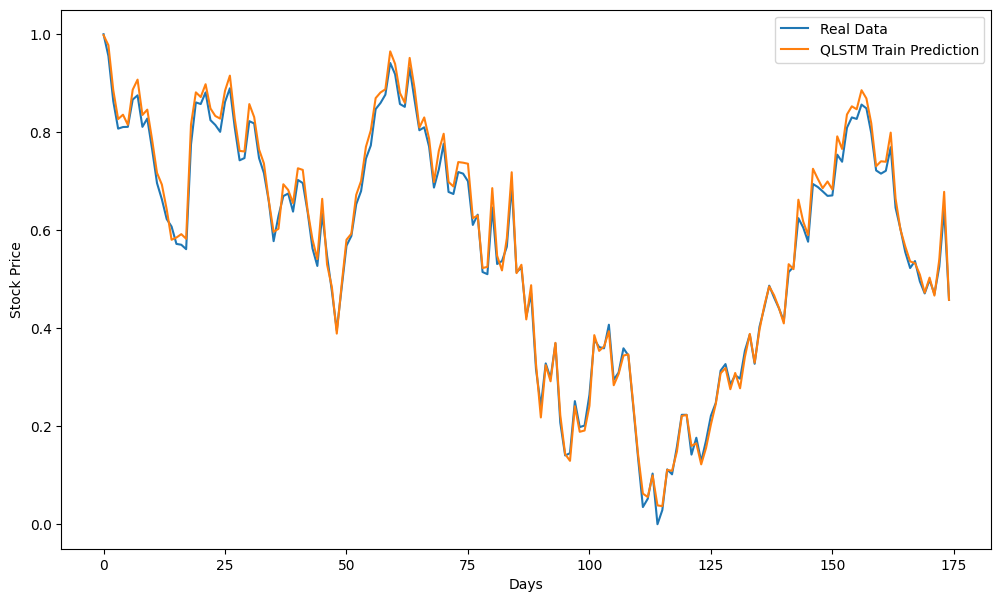

In [17]:
plt.figure(figsize=(12, 7))
plt.plot(range(len(df_train)), df_train["Close"], label = "Real Data")
plt.plot(range(len(df_train)), df_train["Model Forecast"], label = "QLSTM Train Prediction")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.legend()
plt.show()